<a href="https://colab.research.google.com/github/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications/blob/akhila_branch/sentiment_analysis_drug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install transformers textblob pandas scikit-learn nltk seaborn --quiet

In [ ]:
#Import libraries
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import classification_report, accuracy_score
import random
from textblob import TextBlob
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#clear Memory cache
import torch
torch.cuda.empty_cache()
print("GPU memory cleared.")

GPU memory cleared.


In [ ]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load datasets
train_df = pd.read_csv('/content/drive/My Drive/Team Project A/Dataset/Drug_review/drugLibTrain_raw.tsv', sep='\t')
test_df = pd.read_csv('/content/drive/My Drive/Team Project A/Dataset/Drug_review/drugLibTest_raw.tsv', sep='\t')

In [ ]:
# View the dataset
print(train_df.columns)
train_df.head()

Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [ ]:
train_df.isna().sum()

,0
Unnamed: 0,0
urlDrugName,0
rating,0
effectiveness,0
sideEffects,0
condition,1
benefitsReview,18
sideEffectsReview,75
commentsReview,12


In [ ]:
# Keep only relevant columns
df = train_df[['rating', 'benefitsReview', 'sideEffectsReview', 'commentsReview']].dropna()

In [ ]:
# Text features
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

def get_length(text):
    return len(str(text))

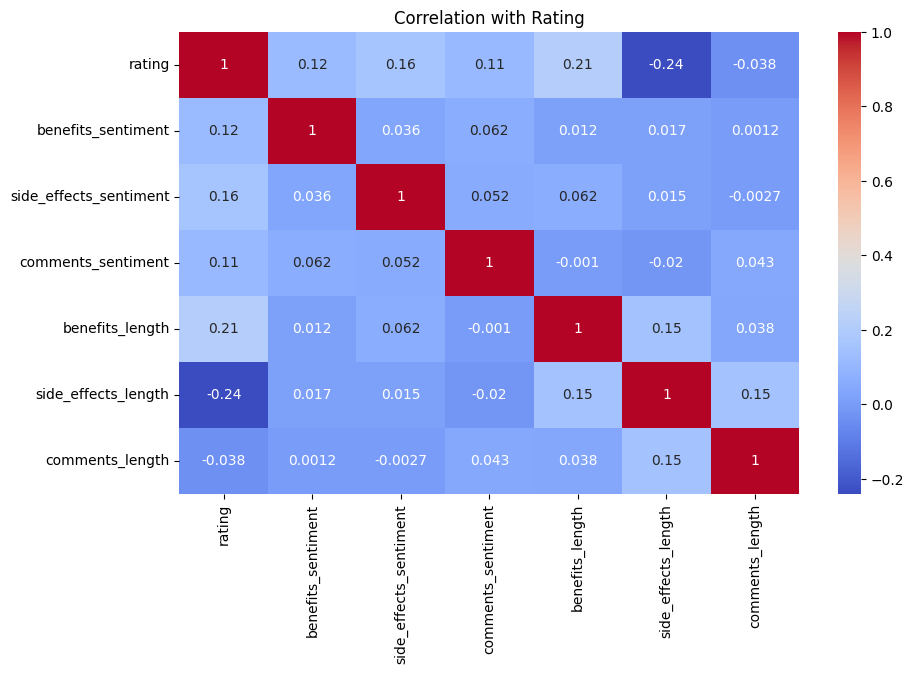

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create features
df['benefits_sentiment'] = df['benefitsReview'].apply(get_sentiment)
df['side_effects_sentiment'] = df['sideEffectsReview'].apply(get_sentiment)
df['comments_sentiment'] = df['commentsReview'].apply(get_sentiment)

df['benefits_length'] = df['benefitsReview'].apply(get_length)
df['side_effects_length'] = df['sideEffectsReview'].apply(get_length)
df['comments_length'] = df['commentsReview'].apply(get_length)

# Correlation matrix
corr_matrix = df[['rating',
                  'benefits_sentiment', 'side_effects_sentiment', 'comments_sentiment',
                  'benefits_length', 'side_effects_length', 'comments_length']].corr()

# Visualize
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation with Rating")
plt.show()


Benefit_review and sideeffect_reviews are highly correlated so I am using both columns

In [ ]:
# Drop missing values
train_df = train_df[['rating', 'benefitsReview', 'sideEffectsReview']].dropna()
test_df = test_df[['rating', 'benefitsReview', 'sideEffectsReview']].dropna()

In [ ]:
train_df.head()

,rating,benefitsReview,sideEffectsReview
0,4,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ..."
1,1,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon..."
2,10,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.
3,3,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines..."
4,2,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...


In [ ]:
# Define sentiment based on rating
def get_sentiment(rating):
    if rating >= 7:
        return 'positive'
    elif rating <= 4:
        return 'negative'
    else:
        return 'neutral'

# Map sentiment
train_df['sentiment'] = train_df['rating'].apply(get_sentiment)
test_df['sentiment'] = test_df['rating'].apply(get_sentiment)

In [ ]:
train_df.head()

,rating,benefitsReview,sideEffectsReview,sentiment
0,4,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...",negative
1,1,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...",negative
2,10,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,positive
3,3,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",negative
4,2,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,negative


In [ ]:
# Combine review columns
train_df['combined_text'] = train_df['benefitsReview'] + " " + train_df['sideEffectsReview']
test_df['combined_text'] = test_df['benefitsReview'] + " " + test_df['sideEffectsReview']

In [ ]:
train_df.head()

,rating,benefitsReview,sideEffectsReview,sentiment,combined_text
0,4,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...",negative,slowed the progression of left ventricular dys...
1,1,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...",negative,Although this type of birth control has more c...
2,10,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,positive,I was used to having cramps so badly that they...
3,3,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",negative,The acid reflux went away for a few months aft...
4,2,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,negative,I think that the Lyrica was starting to help w...


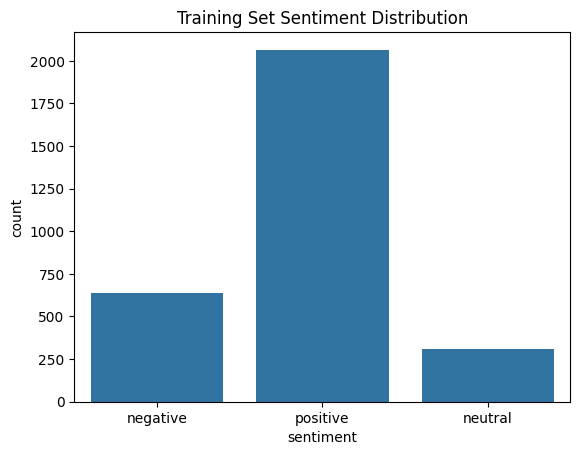

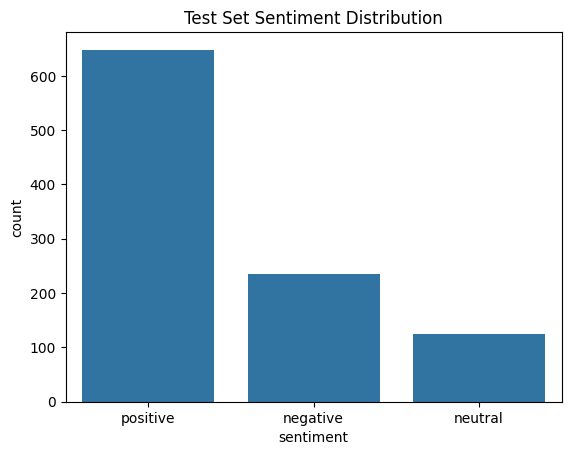

In [ ]:
#checking data imbalance
import seaborn as sns
import matplotlib.pyplot as plt

# Training set plot
sns.countplot(data=train_df, x='sentiment')
plt.title("Training Set Sentiment Distribution")
plt.show()

# Test set plot
sns.countplot(data=test_df, x='sentiment')
plt.title("Test Set Sentiment Distribution")
plt.show()


In [ ]:
from nltk.corpus import wordnet

# 6. Synonym replacement for data augmentation
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random.shuffle(new_words)
    replaced = 0
    for i, word in enumerate(new_words):
        synsets = wordnet.synsets(word)
        if synsets:
            lemmas = synsets[0].lemmas()
            if lemmas:
                syn_word = lemmas[0].name().replace("_", " ")
                if syn_word.lower() != word.lower():
                    new_words[i] = syn_word
                    replaced += 1
        if replaced >= n:
            break
    return ' '.join(new_words)


In [ ]:
# 7. Augment minority classes
def augment_class(df, label, times=2):
    samples = df[df['sentiment'] == label]
    augmented = []
    for _, row in samples.iterrows():
        for _ in range(times):
            new_text = synonym_replacement(row['combined_text'], n=2)
            augmented.append({
                'rating': row['rating'],
                'sentiment': row['sentiment'],
                'combined_text': new_text
            })
    return pd.DataFrame(augmented)

In [ ]:
aug_neutral = augment_class(train_df, 'neutral', times=2)
aug_negative = augment_class(train_df, 'negative', times=1)

In [ ]:
# 8. Combine all training data
train_df_augmented = pd.concat([train_df, aug_neutral, aug_negative], ignore_index=True)

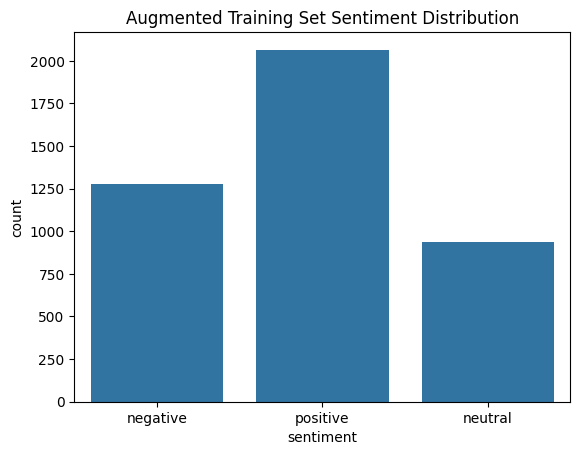

In [ ]:
# 9. Show new class distribution
sns.countplot(data=train_df_augmented, x='sentiment')
plt.title("Augmented Training Set Sentiment Distribution")
plt.show()

In [ ]:
# 10. Load Flan-T5 model with GPU
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using device: cuda


In [ ]:
# After training
train_preds = predict_sentiment(train_df_augmented['combined_text'].tolist())
print("Training Performance:")
print(classification_report(train_df_augmented['sentiment'], train_preds))

# Already have this:
print("Test Performance:")
print(classification_report(test_df['sentiment'], test_preds))


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Training Performance:
              precision    recall  f1-score   support

    negative       0.52      0.73      0.61      1280
     neutral       0.23      0.16      0.19       936
    positive       0.77      0.68      0.72      2065

    accuracy                           0.58      4281
   macro avg       0.51      0.52      0.51      4281
weighted avg       0.58      0.58      0.57      4281

Test Performance:
              precision    recall  f1-score   support

    negative       0.51      0.77      0.61       235
     neutral       0.06      0.08      0.07       125
    positive       0.85      0.64      0.73       648

    accuracy                           0.60      1008
   macro avg       0.47      0.50      0.47      1008
weighted avg       0.67      0.60      0.62      1008



*   The model isn't overfitting, because test performance is not worse than training.
*   It isn’t underfitting, because positive and negative are doing well.

*  The problem is with the neutral class, which is hard to learn even after augmentation.






In [ ]:
from collections import Counter
print("Prediction distribution:", Counter(test_preds))
print("Actual distribution:", Counter(test_df['sentiment']))


Prediction distribution: Counter({'positive': 490, 'negative': 358, 'neutral': 160})
Actual distribution: Counter({'positive': 648, 'negative': 235, 'neutral': 125})


In [ ]:
# Custom input testing
def test_custom_inputs(texts):
    prompts = ["Is the sentiment of the following review positive, neutral, or negative? Review: " + text for text in texts]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model.generate(inputs.input_ids, max_length=5, num_beams=1, early_stopping=True)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    valid_classes = {'positive', 'neutral', 'negative'}
    clean_preds = [pred.lower().strip() for pred in decoded]
    final_preds = [pred if pred in valid_classes else 'neutral' for pred in clean_preds]

    for text, pred in zip(texts, final_preds):
        print(f"\nReview: {text}\nPredicted Sentiment: {pred}")

# Test it
test_custom_inputs([
    "This medicine worked great and helped me recover fast.",
    "I feel dizzy and tired all day after taking it.",
    "I took the drug as instructed. Nothing changed."
])
